# novelty

testing out how i can calculate the novelty curve of a midi file and add a message with the novelty value at each beat of the midi file

In [1]:
import os
import sys
import pretty_midi
from midi_player import MIDIPlayer
from numba import jit
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

import numpy.typing as npt
from typing import Tuple, Dict

from midi_player.stylers import dark

plt.style.use("dark_background")

## helper functions
from `utils/novelty.py`


In [2]:
def gen_ssm_and_novelty(
    features, L=1, filter_length=41, down_sampling=10, hop=1024, sr=100
):
    features, _ = smooth_downsample_feature_sequence(
        features, sr / hop, filter_length, down_sampling
    )

    print(features.shape)

    ssm = np.dot(np.transpose(features), features)
    novelty = compute_novelty_ssm(ssm, L, exclude=True)

    return ssm, novelty


def get_peaks(data: npt.NDArray, Thalf=10, tau=1.35, distance=7):
    """from SSMNet"""

    nb_frame = len(data)

    # compute peak to mean ratio
    peak_to_mean_v = np.zeros((nb_frame))
    for nu in range(0, nb_frame):
        sss = max(0, nu - Thalf)
        eee = min(nu + Thalf + 1, nb_frame)
        local_mean = np.sum(data[sss:eee]) / (eee - sss)
        peak_to_mean_v[nu] = data[nu] / local_mean if local_mean != 0 else 0

    # find peaks
    peaks, _ = signal.find_peaks(peak_to_mean_v, distance=distance)

    # above threshold tau
    above_threshold = np.where(peak_to_mean_v[peaks] >= tau)[0]

    return peaks[above_threshold]


def get_boundaries(
    novelty: npt.NDArray[np.float64],
    time_sec_v: npt.NDArray[np.float64],
    peak_settings: Dict = {},
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """Estimate the boundaries using the novelty curve.

    Args:
        novelty: the novelty curve
        time_sec_v: an array of seconds indicators
        peak_settings: custom settings for peak detection

    Returns:
        boundary_sec_v: boundary indices in seconds
        boundary_frame_v: boundary indices in frames
    """
    if len(peak_settings.values()) > 0:
        boundary_frame_v = get_peaks(
            novelty,
            peak_settings["Thalf"],
            peak_settings["tau"],
            peak_settings["distance"],
        )
    else:
        boundary_frame_v = get_peaks(
            novelty,
        )
    boundary_sec_v = time_sec_v[boundary_frame_v]

    # add start and end-time
    boundary_sec_v = np.concatenate(
        (0 * np.ones(1), boundary_sec_v, time_sec_v[-1] * np.ones(1))
    )

    # to be sure there is not twice zero
    boundary_sec_v = np.array(sorted([aaa for aaa in set(boundary_sec_v)]))

    return boundary_sec_v, boundary_frame_v


def compute_novelty_ssm(
    S, kernel=None, L=10, var=0.5, exclude=False
) -> npt.NDArray[np.float64]:
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2 * L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode="constant")

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n : n + M, n : n + M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N - L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov


@jit(nopython=True)
def compute_kernel_checkerboard_gaussian(
    L, var=1.0, normalize=True
) -> npt.NDArray[np.float64]:
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1 / 2) / (L * var)
    axis = np.arange(-L, L + 1)
    gaussian1D = np.exp(-(taper**2) * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D

    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))

    return kernel


def smooth_downsample_feature_sequence(
    X, Fs, filt_len=41, down_sampling=10, w_type="boxcar"
):
    """Smoothes and downsamples a feature sequence. Smoothing is achieved by convolution with a filter kernel

    Notebook: C3/C3S1_FeatureSmoothing.ipynb

    Args:
        X (np.ndarray): Feature sequence
        Fs (scalar): Frame rate of ``X``
        filt_len (int): Length of smoothing filter (Default value = 41)
        down_sampling (int): Downsampling factor (Default value = 10)
        w_type (str): Window type of smoothing filter (Default value = 'boxcar')

    Returns:
        X_smooth (np.ndarray): Smoothed and downsampled feature sequence
        Fs_feature (scalar): Frame rate of ``X_smooth``
    """
    filt_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth = signal.convolve(X, filt_kernel, mode="same") / filt_len
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_feature = Fs / down_sampling
    return X_smooth, Fs_feature

In [3]:
def trim_piano_roll(piano_roll, min=None, max=None):
    """
    Trims the piano roll by removing rows above the highest note and below the
    lowest note.

    Parameters:
        piano_roll (np.array): A 2D NumPy array representing the piano roll.
        min (int): The note to remove everything below. If none is provided, the
        lowest note in the roll will be used
        max (int): The note to remove everything above. If none is provided, the
        highest note in the roll will be used

    Returns:
        np.array: The trimmed piano roll.
    """
    non_zero_rows = np.where(np.any(piano_roll > 0, axis=1))[0]

    if non_zero_rows.size == 0:
        return piano_roll

    lowest_note = non_zero_rows.min() if min is None else min
    highest_note = non_zero_rows.max() if max is None else max

    trimmed_piano_roll = piano_roll[lowest_note : highest_note + 1, :]

    return trimmed_piano_roll

In [4]:
def calc_beats(tempo: int, start_time_seconds: float, end_time_seconds: float):
    """Compute the timing for each beat based on the given tempo, starting
    from 'start_time_seconds' until 'end_time_seconds'. Each beat's timing is
    calculated and appended to a list, which is then returned. The calculation
    assumes a constant tempo throughout the specified time range, and that
    'start_time_seconds' is a valid first beat.

    Parameters:
        tempo (int): The tempo of the music in beats per minute (BPM).
        start_time_seconds (float): The start time of the time range in seconds.
        end_time_seconds (float): The end time of the time range in seconds.

    Returns:
        list[float]: A list containing the timestamps (in seconds) where each
                        beat occurs within the specified time range.
    """
    beat_duration = 60 / tempo
    current_time = start_time_seconds
    beat_times = []

    while current_time <= end_time_seconds:
        beat_times.append(current_time)
        current_time += beat_duration

    return np.asarray(beat_times)

## test


In [5]:
test_file = "../data/datasets/20250110/unsegmented/20231220-080-01.mid"
midi = pretty_midi.PrettyMIDI(test_file)
piano_roll = midi.get_piano_roll(fs=100)
tempo = 80
beat_len = 60 / tempo
pr_fs = 100
ds = 5
filter_len = int(np.round(pr_fs * beat_len)) * 4
filter_len

300

In [6]:
MIDIPlayer(test_file, 300, styler=dark)

In [7]:
ssm, n_smoothed = gen_ssm_and_novelty(
    piano_roll, filter_length=filter_len, down_sampling=1
)
boundaries = get_boundaries(n_smoothed, np.array(range(n_smoothed.shape[0])))
beats = calc_beats(tempo, 0, midi.get_end_time())

(128, 45225)


In [8]:
boundaries[0]

array([0.0000e+00, 1.0000e+01, 4.5214e+04, 4.5224e+04])

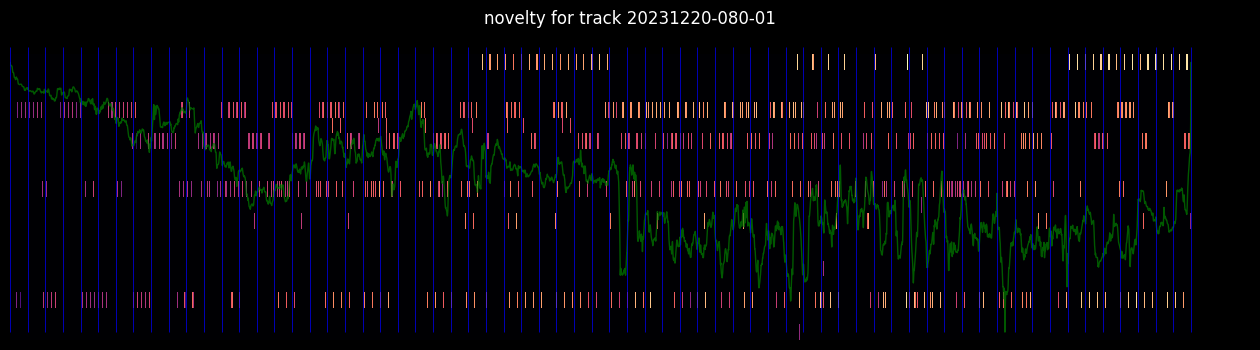

In [9]:
plt.figure(figsize=(16, 4))
# plt.imshow(ssm / ssm.max(), cmap="magma")
plt.imshow(
    trim_piano_roll(piano_roll),
    aspect="auto",
    origin="lower",
    cmap="magma",
    interpolation="nearest",
)
# plt.colorbar()
plt.plot(
    # range(0, len(n_smoothed) * 5, 5),
    (1 - n_smoothed / n_smoothed.max()) * 17,
    "g",
    linewidth=1.0,
    alpha=0.7,
)
# plt.vlines(boundaries[0], 0, 18, "g", linewidth=1, alpha=0.0)
plt.vlines((beats * pr_fs)[::9], 0, 18, "b", linewidth=0.5, alpha=1.0)
plt.axis("off")
plt.title("novelty for track 20231220-080-01")
plt.show()

In [12]:
n_smoothed[:100]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,  3417.3041    ,  3447.1397    ,
        3472.32597778,  3492.6866    ,  3508.0805    ,  3518.40187778,
        3523.5802    ,  3523.5802    ,  3523.5802    ,  3523.5802    ,
        3523.5802    ,  3523.5802    ,  3523.5802    ,  3523.5802    ,
        3523.5802    ,  3523.5802    ,  3523.5802    ,  3523.5802    ,
        3523.5802    ,  3523.5802    ,  3523.5971    ,  3523.7323    ,
        3524.1886    ,  3525.2702    ,  3527.3827    ,  3531.0331    ,
        3536.8298    ,  3545.4826    ,  3557.8027    ,  3574.7027    ,
        3597.1966    ,  3623.7803    ,  3654.4538    ,  3689.2171    ,
        3728.0702    ,  3771.0131    ,  3818.0458    ,  3869.1683    ,
        3924.3806    ,  3983.6827    ,  4047.0746    ,  4108.2526    ,
        4166.2027    ,  4220.0123    ,  4268.8702    ,  4312.0666    ,
      